In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from itertools import cycle
from sklearn.inspection import permutation_importance
import shap



In [5]:
# prompt: mount

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import shap
import warnings
warnings.filterwarnings('ignore')

In [16]:
df_metabolite = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/metabolites_training.csv")


Model: KNN
                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.90      0.94      0.92      1436
             Basal-like 2 (BL2)       0.92      0.94      0.93      1495
Luminal Androgen Receptor (LAR)       0.90      0.95      0.93      1933
                Mesenchymal (M)       0.97      0.88      0.93      2192

                       accuracy                           0.93      7056
                      macro avg       0.93      0.93      0.93      7056
                   weighted avg       0.93      0.93      0.93      7056



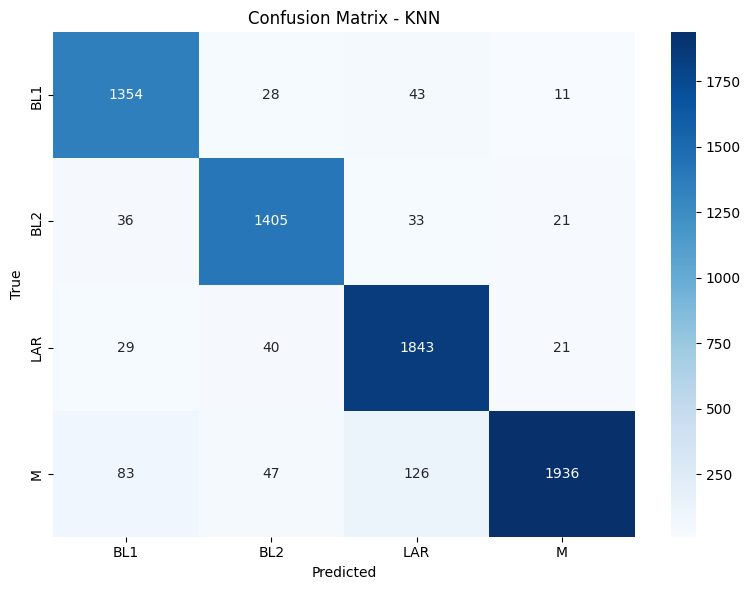


Model: SVM
                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.76      0.83      0.79      1436
             Basal-like 2 (BL2)       0.79      0.66      0.72      1495
Luminal Androgen Receptor (LAR)       0.79      0.84      0.82      1933
                Mesenchymal (M)       0.85      0.84      0.85      2192

                       accuracy                           0.80      7056
                      macro avg       0.80      0.79      0.79      7056
                   weighted avg       0.80      0.80      0.80      7056



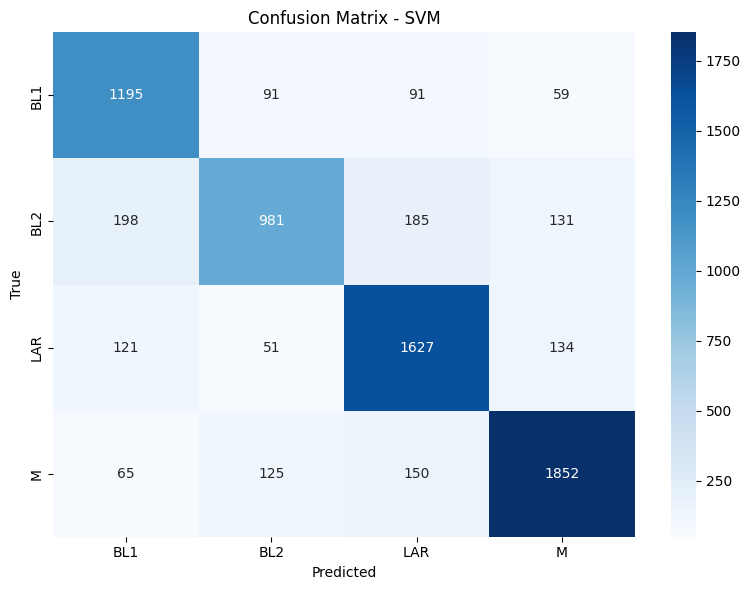


Model: XGBoost
                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.91      0.87      0.89      1436
             Basal-like 2 (BL2)       0.87      0.86      0.87      1495
Luminal Androgen Receptor (LAR)       0.89      0.90      0.90      1933
                Mesenchymal (M)       0.88      0.91      0.90      2192

                       accuracy                           0.89      7056
                      macro avg       0.89      0.89      0.89      7056
                   weighted avg       0.89      0.89      0.89      7056



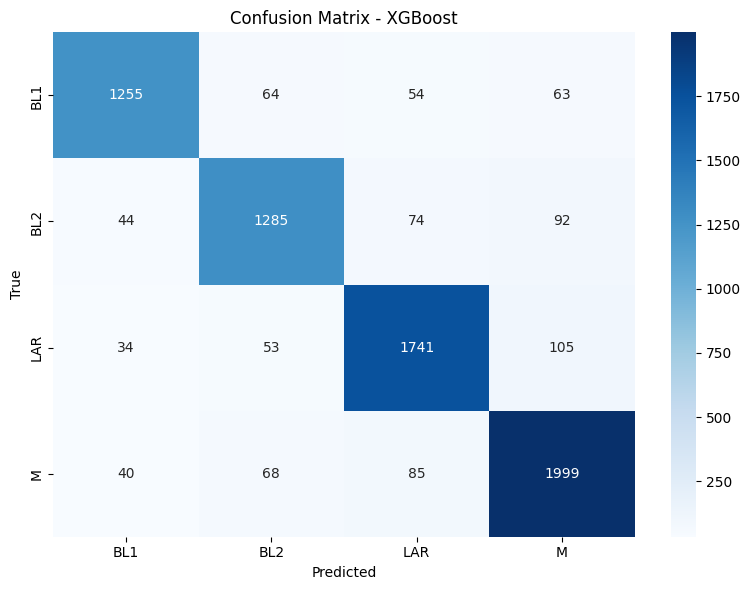


Model: Logistic Regression
                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.78      0.80      0.79      1436
             Basal-like 2 (BL2)       0.80      0.63      0.70      1495
Luminal Androgen Receptor (LAR)       0.76      0.86      0.81      1933
                Mesenchymal (M)       0.84      0.85      0.85      2192

                       accuracy                           0.80      7056
                      macro avg       0.79      0.79      0.79      7056
                   weighted avg       0.80      0.80      0.79      7056



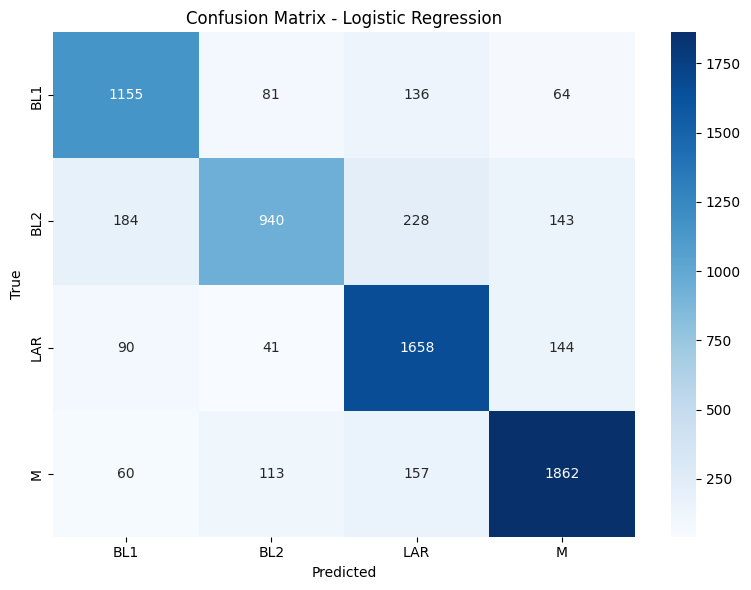

In [17]:


#============================
#  Load and Prepare Data
#============================
X = df_metabolite.drop(columns=['TNBC_Subtype'])
y = df_metabolite['TNBC_Subtype']

# Encode class labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_labels = le.classes_

#============================
#  Train/Test Split
#============================
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

#============================
#  Define Models
#============================
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

#============================
#  Evaluate Models
#============================
best_model = None
best_acc = 0

for name, model in models.items():
    print(f"\nModel: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    y_pred_labels = le.inverse_transform(y_pred)
    y_true_labels = le.inverse_transform(y_test)

    print(classification_report(y_true_labels, y_pred_labels))

    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=class_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['BL1', 'BL2', 'LAR', 'M'], yticklabels=['BL1', 'BL2', 'LAR', 'M'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    acc = np.mean(y_pred == y_test)
    if acc > best_acc:
        best_acc = acc
        best_model = (name, model)

In [20]:


#============================
#  SHAP Analysis with KernelExplainer
#============================
shap.initjs()
print(f"\nBest Model: {best_model[0]} with Accuracy: {best_acc:.4f}")
explainer = shap.KernelExplainer(best_model[1].predict_proba, shap.sample(X_train, 100))
shap_values = explainer.shap_values(shap.sample(X_test, 100))


Best Model: KNN with Accuracy: 0.9266


  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Axes has not been added yet

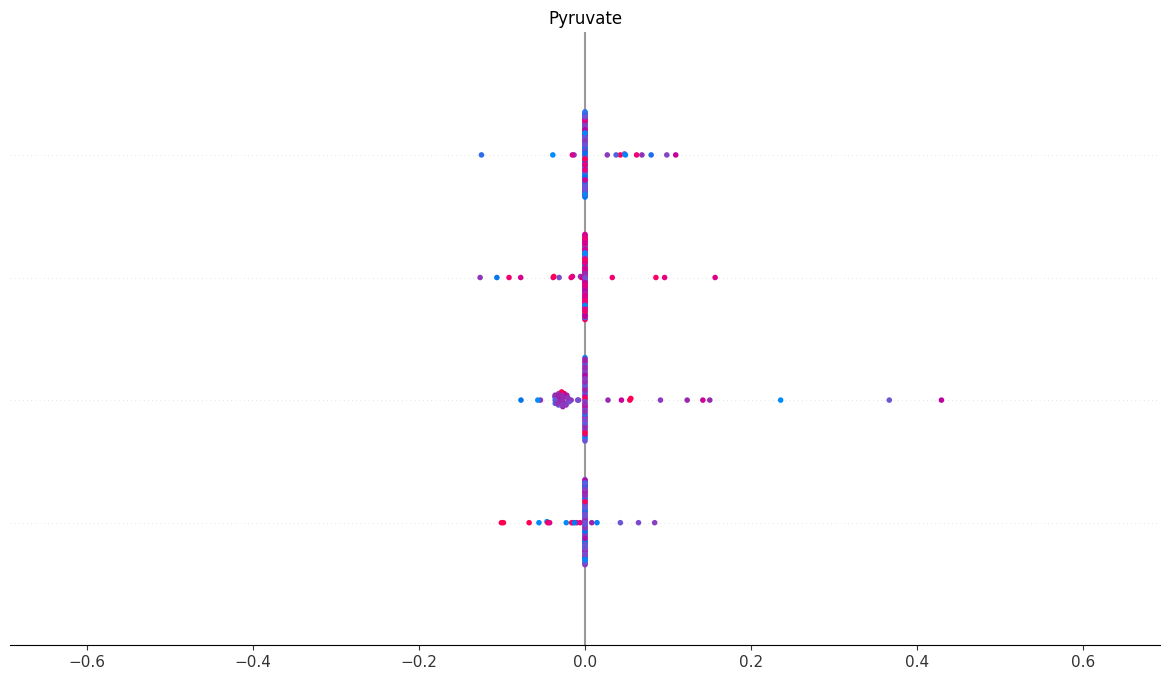

<Figure size 1600x600 with 0 Axes>

In [18]:


#============================
#  1. Overall SHAP + Feature Importance
#============================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

shap.summary_plot(shap_values, shap.sample(X_test, 100), feature_names=X.columns, plot_type='dot', class_names=class_labels, show=False)
plt.sca(axes[0])
plt.title("Overall SHAP Summary")

shap_vals = np.abs(shap_values).mean(axis=1).mean(axis=0)
top_indices = np.argsort(shap_vals)[-10:][::-1]

importance_df = pd.DataFrame({
    'Feature': X.columns[top_indices],
    'Importance': shap_vals[top_indices]
})

sns.barplot(y='Feature', x='Importance', data=importance_df, ax=axes[1], palette='Reds_r')
axes[1].set_title("Global Feature Importance (Top 10)")

plt.tight_layout()
plt.show()



In [ ]:

#============================
#  2. SHAP Summary Per TNBC Subtype + Importance
#============================
for i, subtype in enumerate(class_labels):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    shap.summary_plot(shap_values[i], shap.sample(X_test, 100), feature_names=X.columns, plot_type='dot', show=False)
    plt.sca(axes[0])
    plt.title(f"SHAP Summary for {subtype}")

    class_vals = np.abs(shap_values[i]).mean(axis=0)
    top_idx = np.argsort(class_vals)[-10:][::-1]

    sub_importance = pd.DataFrame({
        'Feature': X.columns[top_idx],
        'Importance': class_vals[top_idx]
    })

    sns.barplot(y='Feature', x='Importance', data=sub_importance, ax=axes[1], palette='Reds_r')
    axes[1].set_title(f"{subtype} Feature Importance (Top 10)")

    plt.tight_layout()
    plt.show()


##====SHAP FULL CODE ============

In [21]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Sample 500 rows for SHAP efficiency
sample_idx = np.random.choice(range(X.shape[0]), size=500, replace=False)
X_sample = X.iloc[sample_idx]

class_labels = ['BL1', 'BL2', 'M', 'LAR']  # TNBC subtype labels

for model_name, model_cv in best_models.items():
    print(f"\n==============================")
    print(f"🔎 SHAP Analysis for {model_name}")
    print(f"==============================")

    model = model_cv.best_estimator_

    # Detect if pipeline, extract classifier
    if hasattr(model, "named_steps"):
        clf = model.named_steps[list(model.named_steps)[-1]]
        predict_func = lambda data: model.predict_proba(data)
    else:
        clf = model
        predict_func = lambda data: clf.predict_proba(data)

    # Use appropriate SHAP explainer
    if model_name == "XGBoost":
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_sample)
    else:
        background = shap.kmeans(X_sample.values, 10)
        explainer = shap.KernelExplainer(predict_func, background)
        shap_values = explainer.shap_values(X_sample, nsamples=100)



NameError: name 'best_models' is not defined

In [ ]:
# =============================
    # 🔘 Overall SHAP Summary
    # =============================
    shap.summary_plot(shap_values, X_sample, plot_type='dot', max_display=10)

    # Compute overall top 10 features
    if model_name == "XGBoost":
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
    else:
        mean_abs_shap = np.abs(shap_values).mean(axis=1).mean(axis=0)

    top10_idx = np.argsort(mean_abs_shap)[-10:]
    top10_features = X_sample.columns[top10_idx]
    top10_means = mean_abs_shap[top10_idx]

    plt.figure(figsize=(6, 5))
    plt.barh(top10_features, top10_means, color='red')
    plt.xlabel("Mean |SHAP Value|")
    plt.title(f"🔴 {model_name} - Global Feature Importance (Top 10)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()



In [ ]:
# =============================
    # 🧬 TNBC Subtype-Specific SHAP
    # =============================
    for class_idx, subtype in enumerate(class_labels):
        print(f"\n🧬 {model_name} - Subtype: {subtype}")

        if model_name == "XGBoost":
            shap_class = shap_values[class_idx]
        else:
            shap_class = shap_values[class_idx]

        shap.summary_plot(shap_class, X_sample, plot_type='dot', max_display=10, class_names=[subtype])

        mean_abs_subtype = np.abs(shap_class).mean(axis=0)
        top10_idx = np.argsort(mean_abs_subtype)[-10:]
        top10_features = X_sample.columns[top10_idx]
        top10_means = mean_abs_subtype[top10_idx]

        plt.figure(figsize=(6, 5))
        plt.barh(top10_features, top10_means, color='red')
        plt.xlabel("Mean |SHAP Value|")
        plt.title(f"🔴 {model_name} - {subtype} Feature Importance (Top 10)")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()


Results for Logistic Regression:
Accuracy: 0.7901
Precision: 0.7904
Recall: 0.7901
F1-Score: 0.7875
Classification Report:
                                 precision    recall  f1-score   support

             Basal-like 2 (BL2)       0.77      0.78      0.78      1434
             Basal-like 1 (BL1)       0.79      0.62      0.69      1490
Luminal Androgen Receptor (LAR)       0.77      0.85      0.81      1924
                Mesenchymal (M)       0.83      0.86      0.84      2208

                       accuracy                           0.79      7056
                      macro avg       0.79      0.78      0.78      7056
                   weighted avg       0.79      0.79      0.79      7056



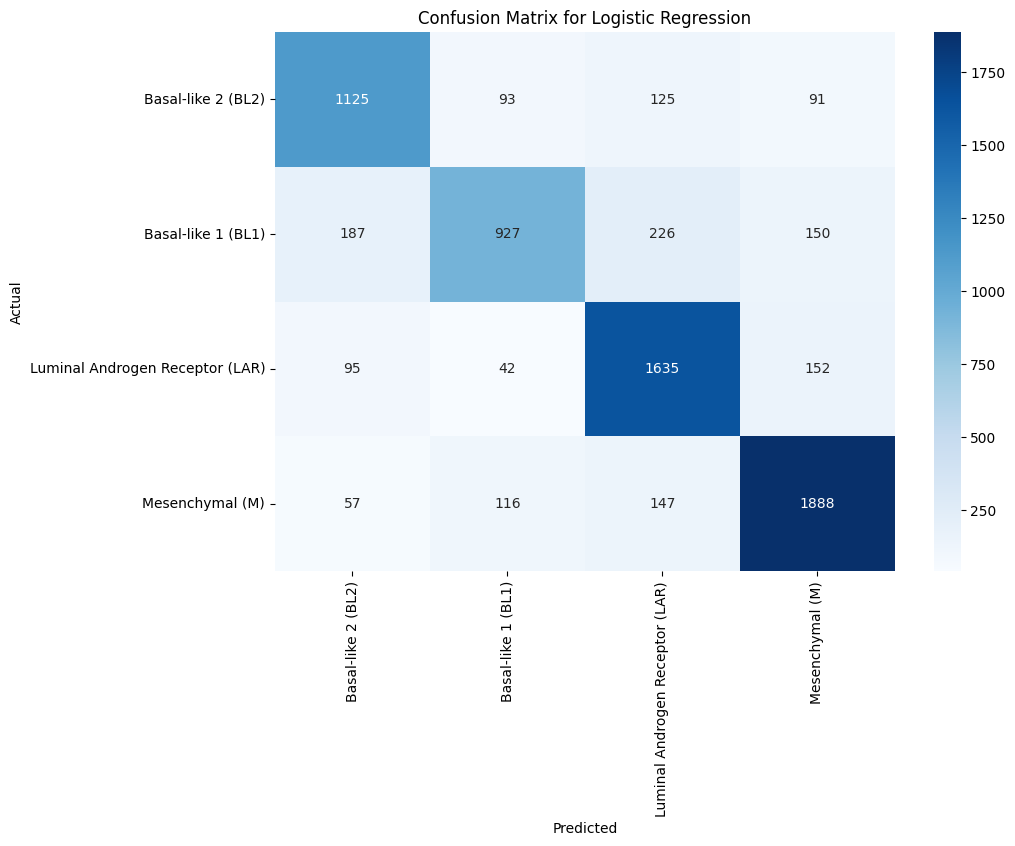

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


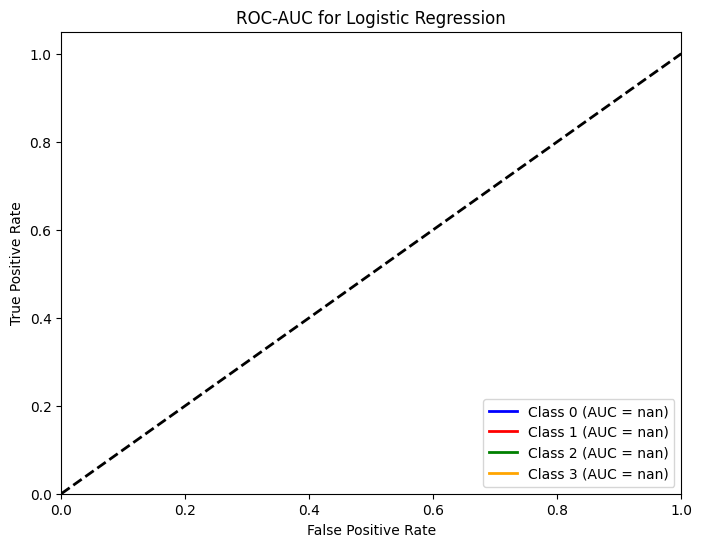

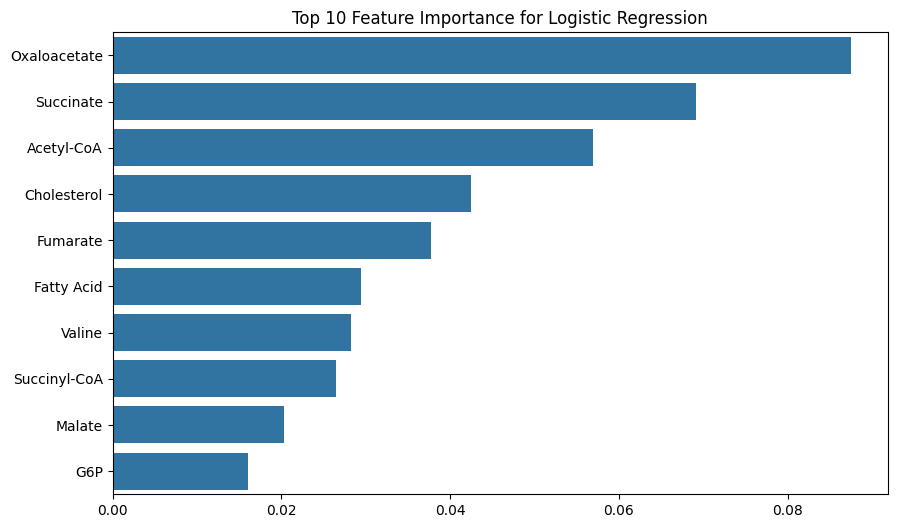

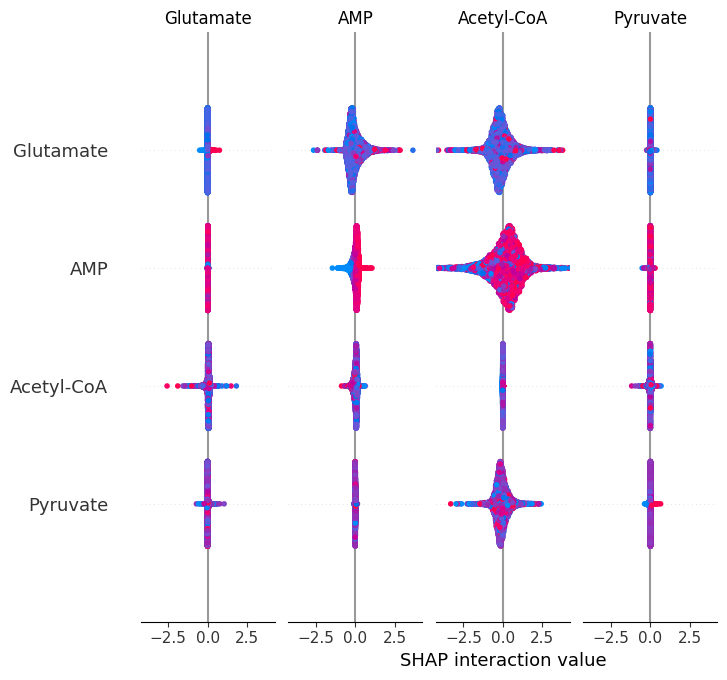

Results for Random Forest:
Accuracy: 0.8441
Precision: 0.8452
Recall: 0.8441
F1-Score: 0.8438
Classification Report:
                                 precision    recall  f1-score   support

             Basal-like 2 (BL2)       0.88      0.81      0.84      1434
             Basal-like 1 (BL1)       0.83      0.78      0.80      1490
Luminal Androgen Receptor (LAR)       0.87      0.87      0.87      1924
                Mesenchymal (M)       0.82      0.89      0.85      2208

                       accuracy                           0.84      7056
                      macro avg       0.85      0.84      0.84      7056
                   weighted avg       0.85      0.84      0.84      7056



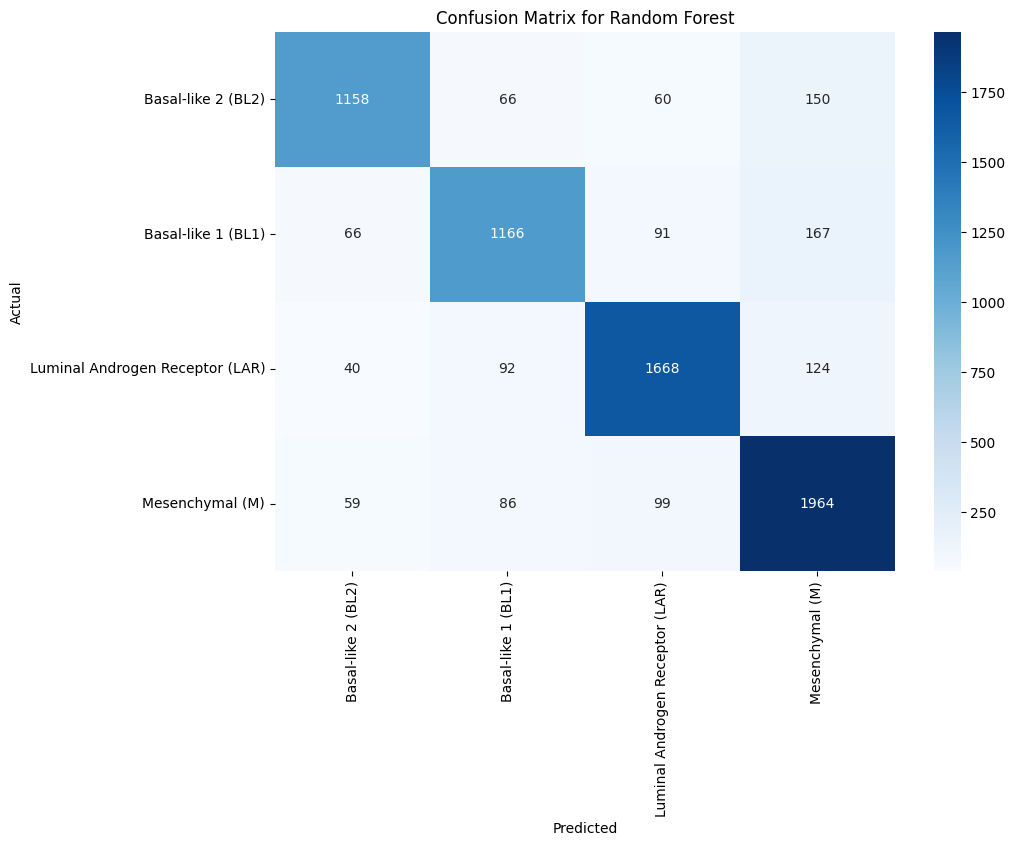

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


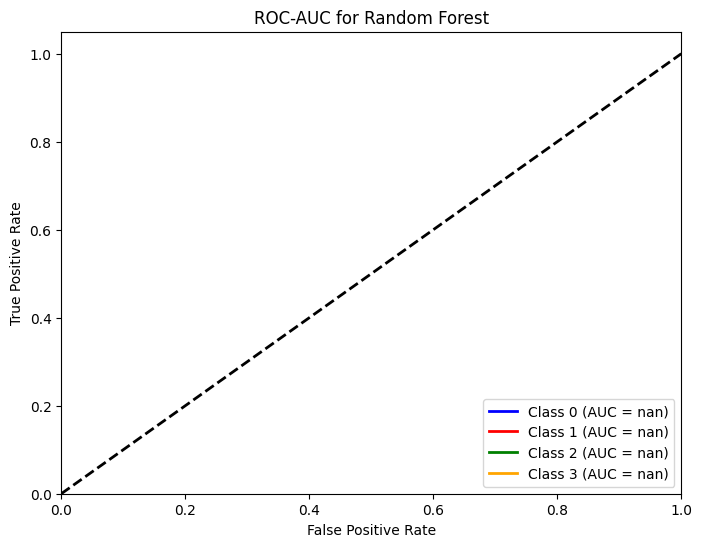

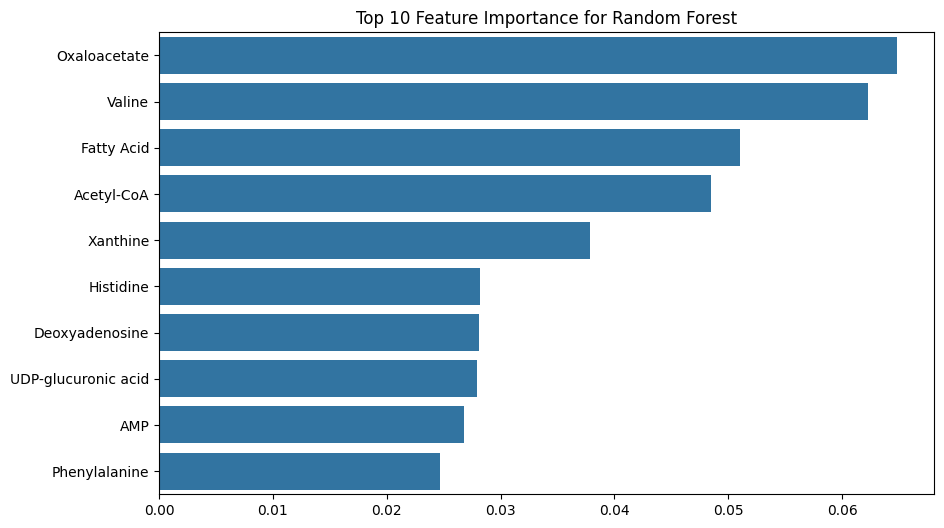

100%|===================| 28222/28224 [65:54<00:00]       

SHAP Error for Random Forest: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.890000, while the model output was 0.880000. If this difference is acceptable you can set check_additivity=False to disable this check.
Results for Support Vector Machine (SVM):
Accuracy: 0.7952
Precision: 0.7949
Recall: 0.7952
F1-Score: 0.7935
Classification Report:
                                 precision    recall  f1-score   support

             Basal-like 2 (BL2)       0.75      0.82      0.78      1434
             Basal-like 1 (BL1)       0.77      0.65      0.70      1490
Luminal Androgen Receptor (LAR)       0.80      0.84      0.82      1924
                Mesenchymal (M)       0.84      0.84      0.84      2208

                       accuracy        

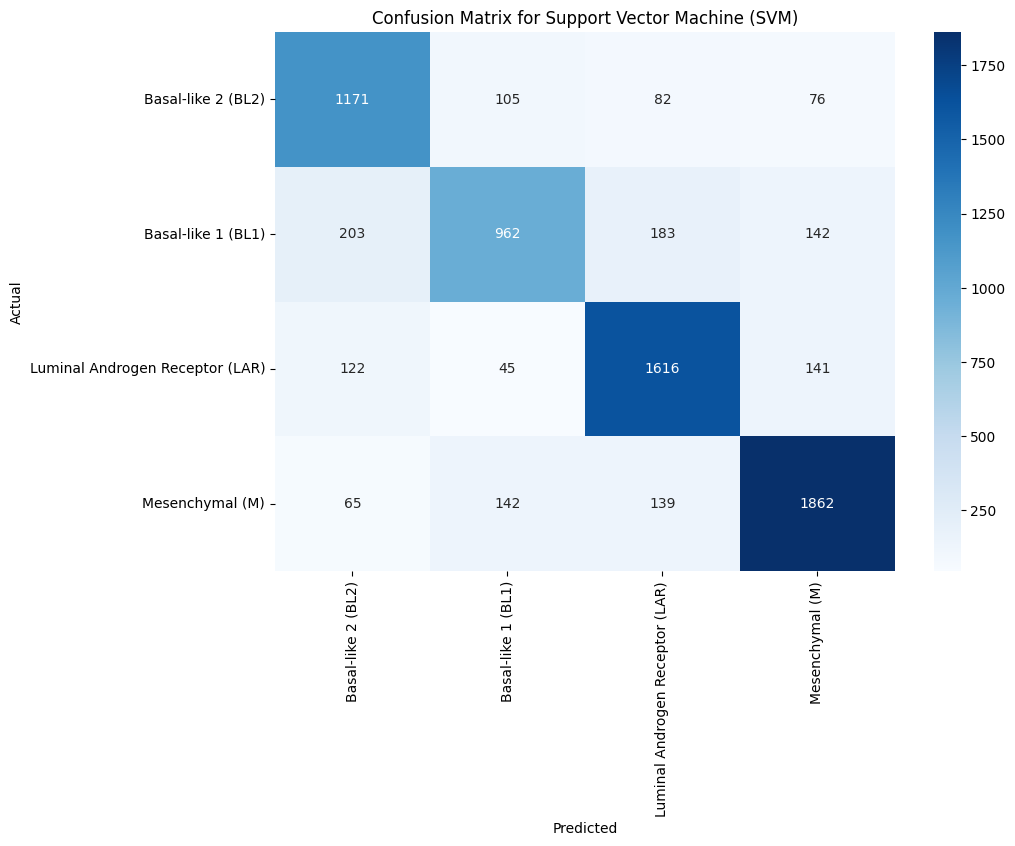

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


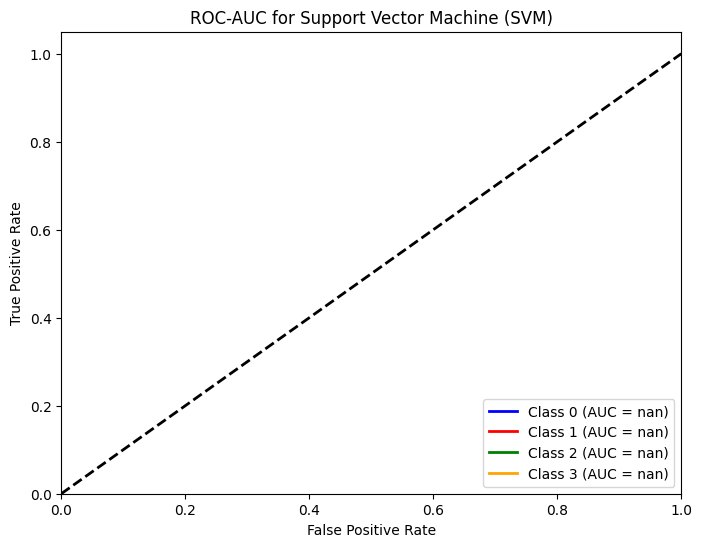

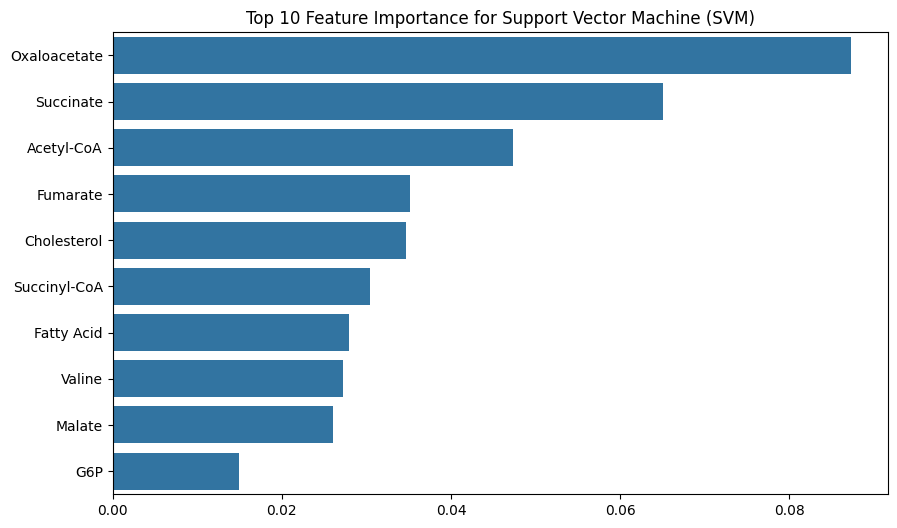

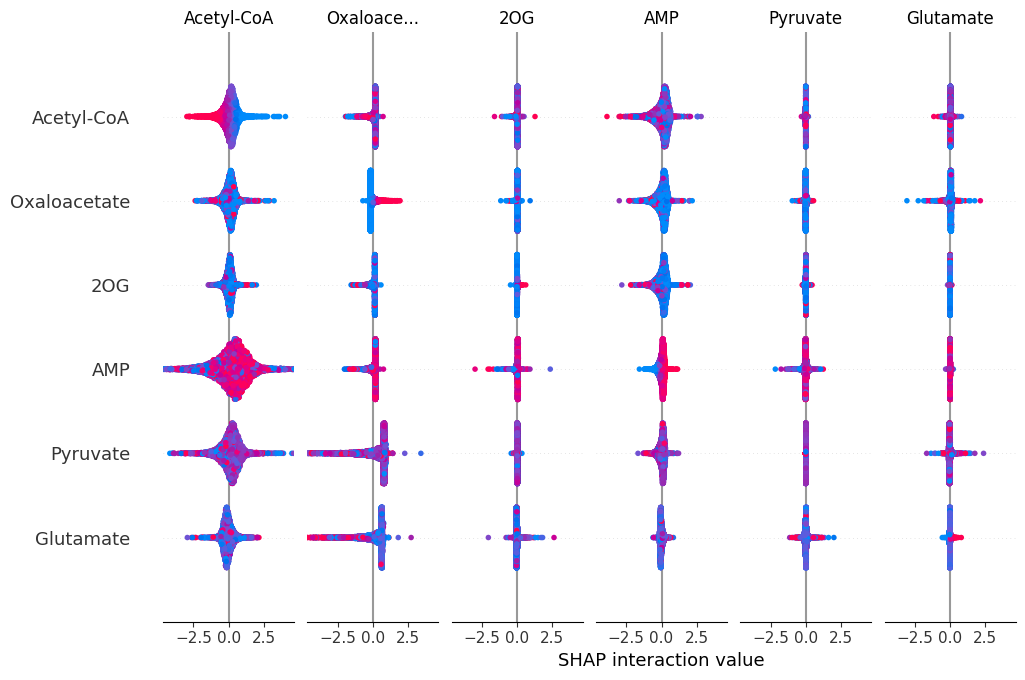

Results for K-Nearest Neighbors (KNN):
Accuracy: 0.9233
Precision: 0.9253
Recall: 0.9233
F1-Score: 0.9232
Classification Report:
                                 precision    recall  f1-score   support

             Basal-like 2 (BL2)       0.89      0.95      0.92      1434
             Basal-like 1 (BL1)       0.91      0.94      0.92      1490
Luminal Androgen Receptor (LAR)       0.92      0.95      0.93      1924
                Mesenchymal (M)       0.97      0.87      0.92      2208

                       accuracy                           0.92      7056
                      macro avg       0.92      0.93      0.92      7056
                   weighted avg       0.93      0.92      0.92      7056



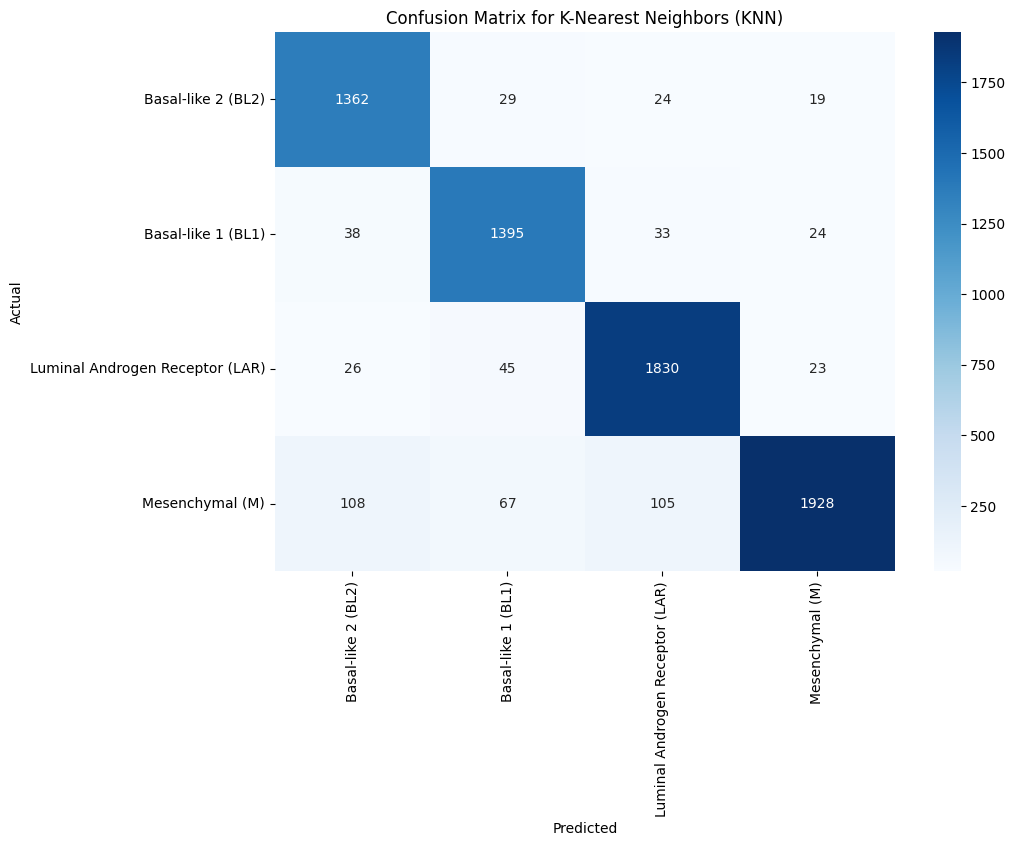

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


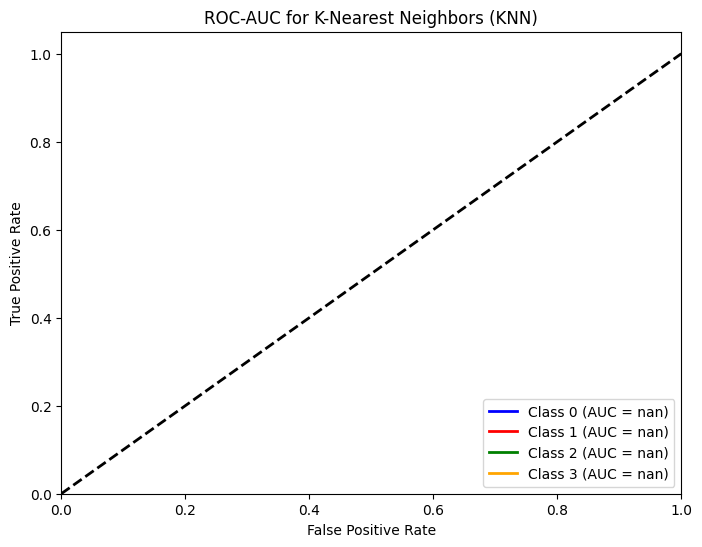

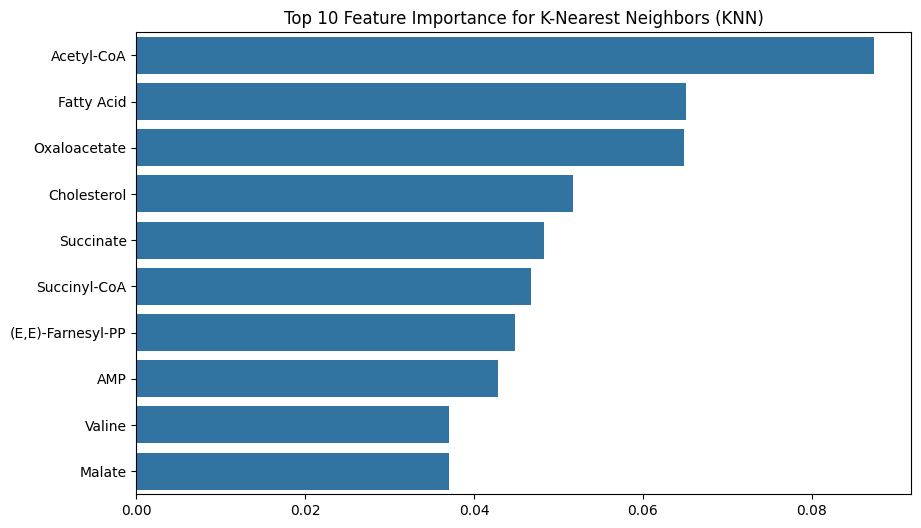

SHAP Error for K-Nearest Neighbors (KNN): can't multiply sequence by non-int of type 'float'


In [ ]:
# Assuming df is your dataset and 'TNBC_Subtype' is the target column

# Split the dataset into features (X) and target (y)
X = df.drop('TNBC_Subtype', axis=1)
y = df['TNBC_Subtype']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define function to train and evaluate each model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)

    # Calculate and print metrics
    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=y.unique()))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # --- ROC-AUC Curves ---
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
        plot_roc_auc(y_test, y_prob, model_name)

    # --- Feature Importance ---
    plot_feature_importance(model, model_name)

    # --- SHAP Values ---
    try:
        if model_name == 'K-Nearest Neighbors (KNN)':
            explainer = shap.KernelExplainer(model.predict, X_train[:100])
        else:
            explainer = shap.Explainer(model, X_train)

        shap_values = explainer(X_test)
        shap.summary_plot(shap_values, X_test, feature_names=X.columns)
    except Exception as e:
        print(f"SHAP Error for {model_name}: {e}")

# Plot ROC-AUC for multi-class classification
def plot_roc_auc(y_test, y_prob, model_name):
    n_classes = y_test.nunique()
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob[:, i])  # Modify this for multiclass one-hot encoding
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    colors = cycle(["blue", "red", "green", "orange"])

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC-AUC for {model_name}")
    plt.legend(loc="lower right")
    plt.show()

# Plot feature importance (Top 10)
def plot_feature_importance(model, model_name):
    try:
        if hasattr(model, "feature_importances_"):
            importance = model.feature_importances_
        else:
            result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
            importance = result.importances_mean

        features = X.columns
        indices = np.argsort(importance)[::-1]

        # Plot top 10 features
        plt.figure(figsize=(10, 6))
        sns.barplot(x=importance[indices][:10], y=[features[i] for i in indices][:10])
        plt.title(f"Top 10 Feature Importance for {model_name}")
        plt.show()
    except Exception as e:
        print(f"Feature Importance Error for {model_name}: {e}")

# Model 1: Logistic Regression
log_reg_model = LogisticRegression(max_iter=1000)
evaluate_model(log_reg_model, X_train, X_test, y_train, y_test, 'Logistic Regression')

# Model 2: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf_model, X_train, X_test, y_train, y_test, 'Random Forest')

# Model 3: Support Vector Machine (SVM)
svm_model = SVC(kernel='linear', probability=True, random_state=42)
evaluate_model(svm_model, X_train, X_test, y_train, y_test, 'Support Vector Machine (SVM)')

# Model 4: K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5)
evaluate_model(knn_model, X_train, X_test, y_train, y_test, 'K-Nearest Neighbors (KNN)')


# ============= USING UMAP DATAFRAME============


### ====================Imports Libraries ========

In [ ]:
#============================
#  Imports
#============================
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:

# Load the data (assuming df is your DataFrame)
df_umap_metabolite = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/metabolites_umap_training.csv")

In [ ]:
#============================
#  Prepare Data
#============================
X = df_umap_metabolite.drop(columns=['TNBC_Subtype'])
y = df_umap_metabolite['TNBC_Subtype']

# Encode class labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_labels = le.classes_


In [ ]:
#============================
#  Model Grid + Pipelines
#============================
models = {
    "KNN": {
        "pipeline": Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier())
        ]),
        "params": {
            'knn__n_neighbors': [3, 5, 7],
            'knn__weights': ['uniform', 'distance'],
            'knn__metric': ['euclidean', 'manhattan']
        }
    },
    "SVM": {
        "pipeline": Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(probability=True))
        ]),
        "params": {
            'svm__C': [0.1, 1, 10],
            'svm__kernel': ['linear', 'rbf'],
            'svm__gamma': ['scale', 'auto']
        }
    },

    "XGBoost": {
    "pipeline": XGBClassifier(eval_metric='mlogloss'),
    "params": {
        'n_estimators': [100, 150],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]

        }
    },


    "Logistic Regression": {
        "pipeline": Pipeline([
            ('scaler', StandardScaler()),
            ('logreg', LogisticRegression(max_iter=1000))
        ]),
        "params": {
            'logreg__C': [0.01, 0.1, 1, 10],
            'logreg__penalty': ['l2'],
            'logreg__solver': ['lbfgs']
        }
    }
}

#============================
#  Perform Grid Search
#============================
best_models = {}
for name, config in models.items():
    print(f"\n Tuning {name}...")
    grid = GridSearchCV(config['pipeline'], config['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X, y_encoded)
    best_models[name] = grid



🔧 Tuning KNN...

🔧 Tuning SVM...

🔧 Tuning XGBoost...

🔧 Tuning Logistic Regression...



Model: KNN
 Best Parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
 Best Cross-Val Accuracy: 0.9572

 Classification Report for KNN:

                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.95      0.96      0.96      7179
             Basal-like 2 (BL2)       0.96      0.95      0.96      7475
Luminal Androgen Receptor (LAR)       0.95      0.97      0.96      9662
                Mesenchymal (M)       0.96      0.95      0.95     10960

                       accuracy                           0.96     35276
                      macro avg       0.96      0.96      0.96     35276
                   weighted avg       0.96      0.96      0.96     35276



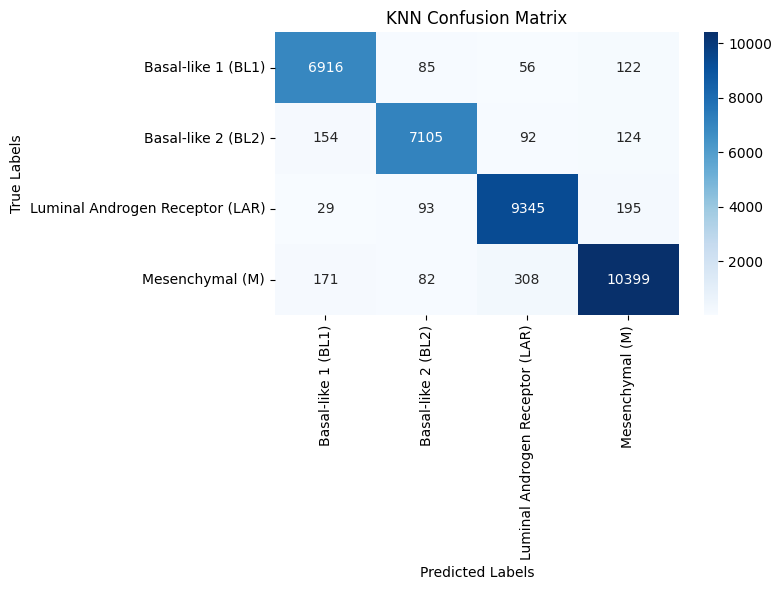

🏁 ROC AUC Score (macro-ovr): 0.9874
🔹 Weighted Precision: 0.9572
🔹 Weighted Recall: 0.9572
🔹 Weighted F1 Score: 0.9572

Model: SVM
 Best Parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
 Best Cross-Val Accuracy: 0.9948

 Classification Report for SVM:

                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       1.00      0.99      0.99      7179
             Basal-like 2 (BL2)       0.99      0.99      0.99      7475
Luminal Androgen Receptor (LAR)       0.99      0.99      0.99      9662
                Mesenchymal (M)       1.00      1.00      1.00     10960

                       accuracy                           0.99     35276
                      macro avg       0.99      0.99      0.99     35276
                   weighted avg       0.99      0.99      0.99     35276



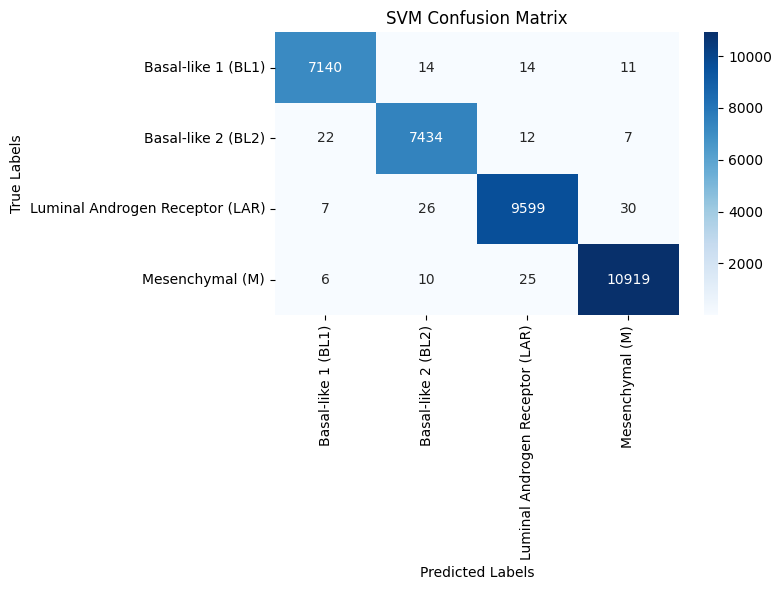

🏁 ROC AUC Score (macro-ovr): 1.0000
🔹 Weighted Precision: 0.9948
🔹 Weighted Recall: 0.9948
🔹 Weighted F1 Score: 0.9948

Model: XGBoost
 Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}
 Best Cross-Val Accuracy: 0.9830

 Classification Report for XGBoost:

                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.98      0.98      0.98      7179
             Basal-like 2 (BL2)       0.98      0.98      0.98      7475
Luminal Androgen Receptor (LAR)       0.98      0.99      0.98      9662
                Mesenchymal (M)       0.99      0.98      0.98     10960

                       accuracy                           0.98     35276
                      macro avg       0.98      0.98      0.98     35276
                   weighted avg       0.98      0.98      0.98     35276



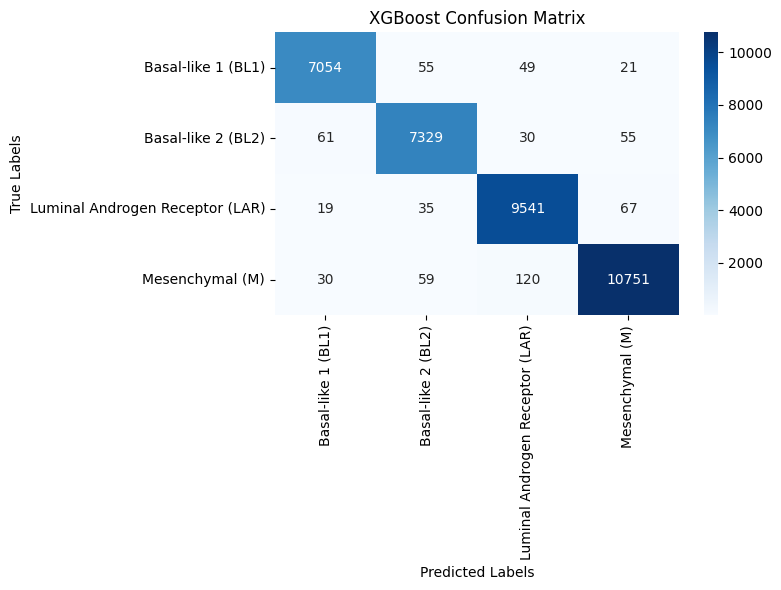

🏁 ROC AUC Score (macro-ovr): 0.9996
🔹 Weighted Precision: 0.9830
🔹 Weighted Recall: 0.9830
🔹 Weighted F1 Score: 0.9830

Model: Logistic Regression
 Best Parameters: {'logreg__C': 10, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
 Best Cross-Val Accuracy: 0.9964

 Classification Report for Logistic Regression:

                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       1.00      1.00      1.00      7179
             Basal-like 2 (BL2)       0.99      1.00      1.00      7475
Luminal Androgen Receptor (LAR)       1.00      1.00      1.00      9662
                Mesenchymal (M)       1.00      1.00      1.00     10960

                       accuracy                           1.00     35276
                      macro avg       1.00      1.00      1.00     35276
                   weighted avg       1.00      1.00      1.00     35276



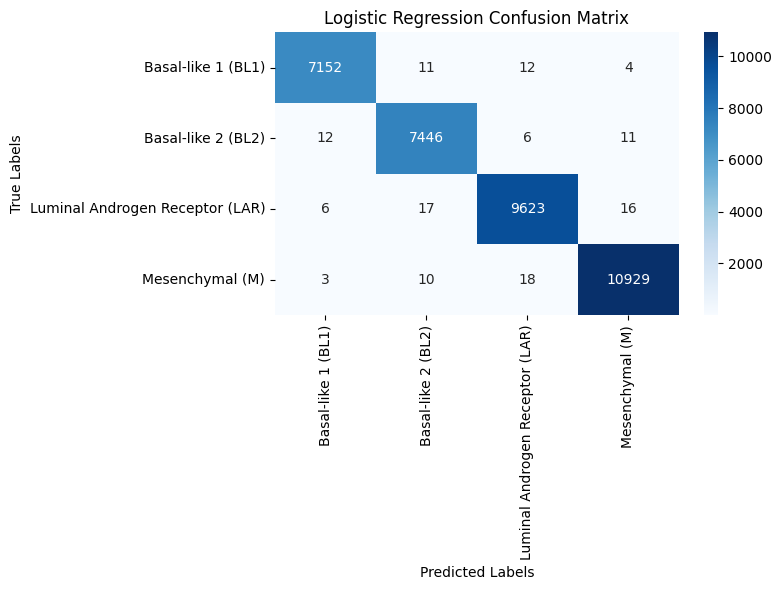

🏁 ROC AUC Score (macro-ovr): 1.0000
🔹 Weighted Precision: 0.9964
🔹 Weighted Recall: 0.9964
🔹 Weighted F1 Score: 0.9964


In [ ]:

#============================
#  Evaluation
#============================
for name, model in best_models.items():
    print(f"\n{'='*30}")
    print(f"Model: {name}")
    print(f"{'='*30}")
    print(f" Best Parameters: {model.best_params_}")
    print(f" Best Cross-Val Accuracy: {model.best_score_:.4f}")

    y_pred = cross_val_predict(model.best_estimator_, X, y_encoded, cv=5)
    y_prob = cross_val_predict(model.best_estimator_, X, y_encoded, cv=5, method='predict_proba')

    # Decode labels back
    y_true_labels = le.inverse_transform(y_encoded)
    y_pred_labels = le.inverse_transform(y_pred)

    # Classification Report
    print(f"\n Classification Report for {name}:\n")
    print(classification_report(y_true_labels, y_pred_labels, target_names=class_labels))

   # Confusion Matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=class_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()

    # Shorten class labels
# class_labels_short = ['BL1', 'BL2', 'LAR', 'M']

# # Confusion Matrix Plot
# cm = confusion_matrix(y_true_labels, y_pred_labels, labels=class_labels)
# plt.figure(figsize=(8, 6))
# sns.set(font_scale=1.4)  # Bigger font
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_labels_short, yticklabels=class_labels_short)
# plt.title(f"{name} Confusion Matrix", fontsize=16)
# plt.xlabel("Predicted Labels", fontsize=14)
# plt.ylabel("True Labels", fontsize=14)
# plt.tight_layout()
# plt.show()

    # ROC AUC Score (One-vs-Rest)
    y_bin = label_binarize(y_encoded, classes=np.unique(y_encoded))
    roc_auc = roc_auc_score(y_bin, y_prob, average='macro', multi_class='ovr')
    print(f"🏁 ROC AUC Score (macro-ovr): {roc_auc:.4f}")

    # Other Metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_labels, y_pred_labels, average='weighted')
    print(f"🔹 Weighted Precision: {precision:.4f}")
    print(f"🔹 Weighted Recall: {recall:.4f}")
    print(f"🔹 Weighted F1 Score: {f1:.4f}")

## ============ USING FULL METABOLITE DATAFRAME============

In [ ]:
#============================
#  Imports
#============================
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd



In [ ]:
# # Load the data (assuming df is your DataFrame)
# df_metabolite = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/metabolites_training.csv")

# Load the data (assuming df is your DataFrame)
df_metabolite = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/metabolites_training.csv")


In [ ]:
#============================
#  Prepare Data
#============================
X = df_metabolite.drop(columns=['TNBC_Subtype'])
y = df_metabolite['TNBC_Subtype']

# Encode class labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_labels = le.classes_


In [ ]:
#============================
#  Model Grid + Pipelines
#============================
models = {
    "KNN": {
        "pipeline": Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier())
        ]),
        "params": {
            'knn__n_neighbors': [3, 5, 7],
            'knn__weights': ['uniform', 'distance'],
            'knn__metric': ['euclidean', 'manhattan']
        }
    },
    "SVM": {
        "pipeline": Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(probability=True))
        ]),
        "params": {
            'svm__C': [0.1, 1, 10],
            'svm__kernel': ['linear', 'rbf'],
            'svm__gamma': ['scale', 'auto']
        }
    },

    "XGBoost": {
    "pipeline": XGBClassifier(eval_metric='mlogloss'),
    "params": {
        'n_estimators': [100, 150],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]

        }
    },


    "Logistic Regression": {
        "pipeline": Pipeline([
            ('scaler', StandardScaler()),
            ('logreg', LogisticRegression(max_iter=1000))
        ]),
        "params": {
            'logreg__C': [0.01, 0.1, 1, 10],
            'logreg__penalty': ['l2'],
            'logreg__solver': ['lbfgs']
        }
    }
}



#============================
#  Perform Grid Search
#============================
# best_models = {}

# for name, config in models.items():
#     print(f"\n🔍 Tuning {name} (CV=3)...")
#     grid = GridSearchCV(config['pipeline'], config['params'], cv=3, scoring='accuracy', n_jobs=-1)
#     grid.fit(X, y_encoded)
#     best_models[name] = grid

best_models = {}
for name, config in models.items():
    print(f"\n Tuning {name}...")
    grid = GridSearchCV(config['pipeline'], config['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X, y_encoded)
    best_models[name] = grid



 Tuning KNN...

 Tuning SVM...

 Tuning XGBoost...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



 Tuning Logistic Regression...



Model: KNN
 Best Parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}
 Best Cross-Val Accuracy: 0.7306

 Classification Report for KNN:

                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.71      0.77      0.74      7179
             Basal-like 2 (BL2)       0.60      0.73      0.66      7475
Luminal Androgen Receptor (LAR)       0.75      0.82      0.78      9662
                Mesenchymal (M)       0.88      0.63      0.73     10960

                       accuracy                           0.73     35276
                      macro avg       0.73      0.74      0.73     35276
                   weighted avg       0.75      0.73      0.73     35276



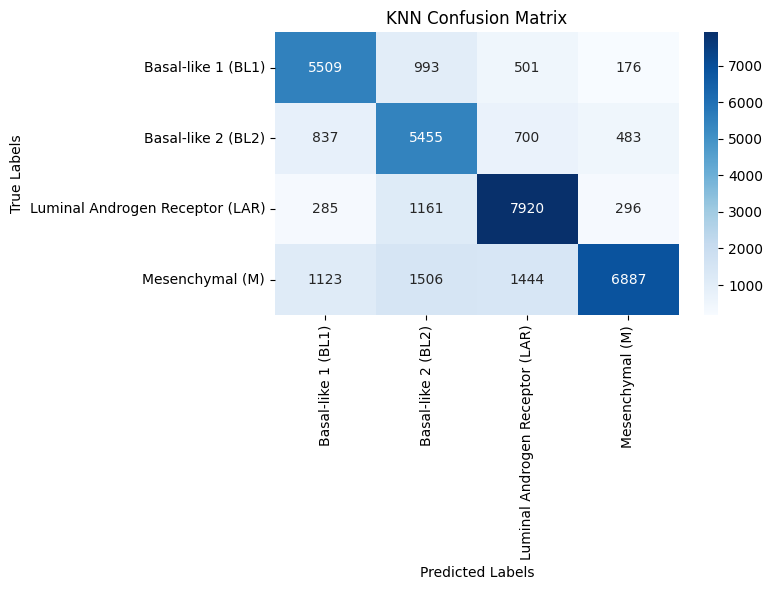

🏁 ROC AUC Score (macro-ovr): 0.9034
🔹 Weighted Precision: 0.7496
🔹 Weighted Recall: 0.7306
🔹 Weighted F1 Score: 0.7316

Model: SVM
 Best Parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
 Best Cross-Val Accuracy: 0.8102

 Classification Report for SVM:

                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.81      0.82      0.82      7179
             Basal-like 2 (BL2)       0.73      0.69      0.71      7475
Luminal Androgen Receptor (LAR)       0.85      0.85      0.85      9662
                Mesenchymal (M)       0.82      0.86      0.84     10960

                       accuracy                           0.81     35276
                      macro avg       0.80      0.80      0.80     35276
                   weighted avg       0.81      0.81      0.81     35276



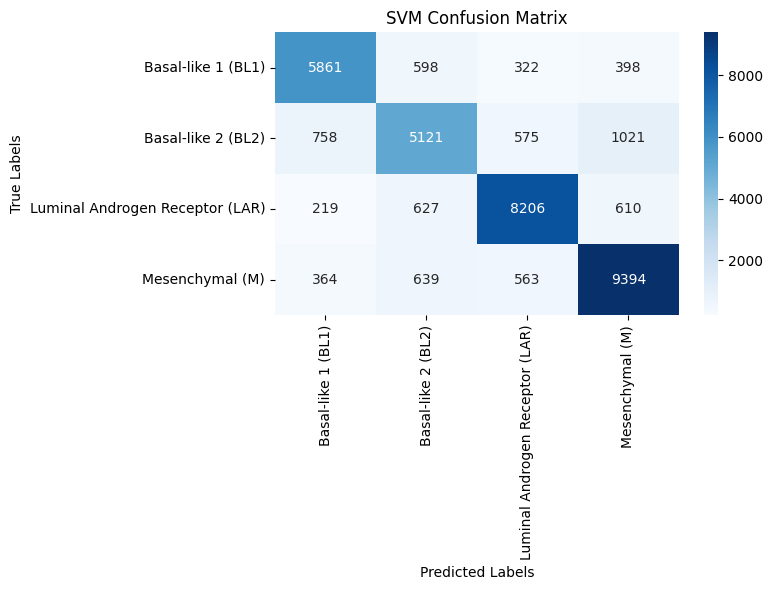

🏁 ROC AUC Score (macro-ovr): 0.9553
🔹 Weighted Precision: 0.8090
🔹 Weighted Recall: 0.8102
🔹 Weighted F1 Score: 0.8093

Model: XGBoost
 Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'subsample': 1.0}
 Best Cross-Val Accuracy: 0.6906

 Classification Report for XGBoost:

                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.73      0.72      0.73      7179
             Basal-like 2 (BL2)       0.45      0.50      0.47      7475
Luminal Androgen Receptor (LAR)       0.76      0.74      0.75      9662
                Mesenchymal (M)       0.79      0.76      0.77     10960

                       accuracy                           0.69     35276
                      macro avg       0.68      0.68      0.68     35276
                   weighted avg       0.70      0.69      0.69     35276



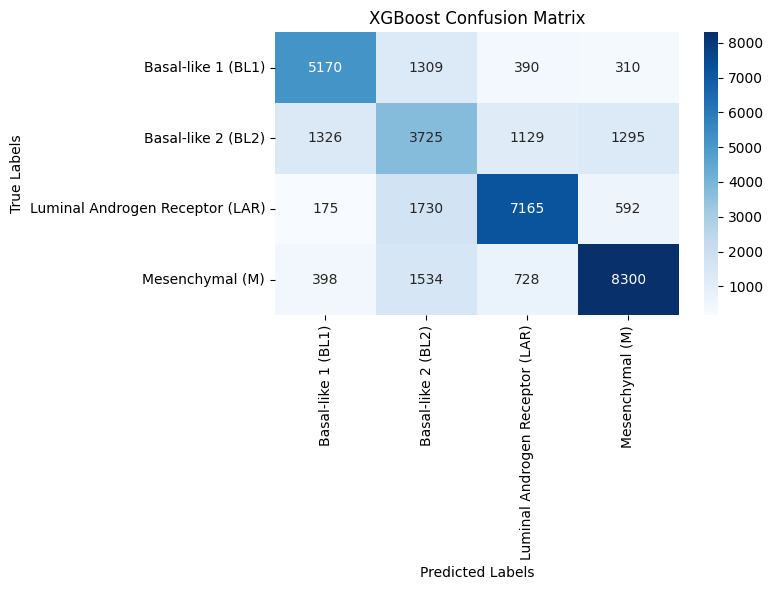

🏁 ROC AUC Score (macro-ovr): 0.8968
🔹 Weighted Precision: 0.6981
🔹 Weighted Recall: 0.6906
🔹 Weighted F1 Score: 0.6939

Model: Logistic Regression
 Best Parameters: {'logreg__C': 0.01, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
 Best Cross-Val Accuracy: 0.7719

 Classification Report for Logistic Regression:

                                 precision    recall  f1-score   support

             Basal-like 1 (BL1)       0.76      0.81      0.78      7179
             Basal-like 2 (BL2)       0.70      0.67      0.68      7475
Luminal Androgen Receptor (LAR)       0.79      0.79      0.79      9662
                Mesenchymal (M)       0.81      0.80      0.81     10960

                       accuracy                           0.77     35276
                      macro avg       0.77      0.77      0.77     35276
                   weighted avg       0.77      0.77      0.77     35276



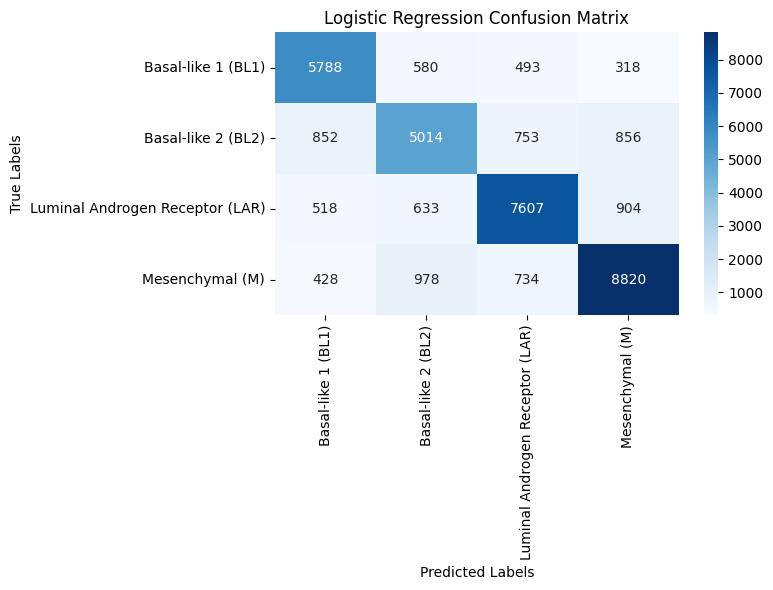

🏁 ROC AUC Score (macro-ovr): 0.9248
🔹 Weighted Precision: 0.7715
🔹 Weighted Recall: 0.7719
🔹 Weighted F1 Score: 0.7715


In [ ]:

#============================
#  Evaluation
#============================
for name, model in best_models.items():
    print(f"\n{'='*30}")
    print(f"Model: {name}")
    print(f"{'='*30}")
    print(f" Best Parameters: {model.best_params_}")
    print(f" Best Cross-Val Accuracy: {model.best_score_:.4f}")

    y_pred = cross_val_predict(model.best_estimator_, X, y_encoded, cv=5)
    y_prob = cross_val_predict(model.best_estimator_, X, y_encoded, cv=5, method='predict_proba')

    # Decode labels back
    y_true_labels = le.inverse_transform(y_encoded)
    y_pred_labels = le.inverse_transform(y_pred)

    # Classification Report
    print(f"\n Classification Report for {name}:\n")
    print(classification_report(y_true_labels, y_pred_labels, target_names=class_labels))

   # Confusion Matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=class_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()

    # Shorten class labels
# class_labels_short = ['BL1', 'BL2', 'LAR', 'M']

# # Confusion Matrix Plot
# cm = confusion_matrix(y_true_labels, y_pred_labels, labels=class_labels)
# plt.figure(figsize=(8, 6))
# sns.set(font_scale=1.4)  # Bigger font
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_labels_short, yticklabels=class_labels_short)
# plt.title(f"{name} Confusion Matrix", fontsize=16)
# plt.xlabel("Predicted Labels", fontsize=14)
# plt.ylabel("True Labels", fontsize=14)
# plt.tight_layout()
# plt.show()

    # ROC AUC Score (One-vs-Rest)
    y_bin = label_binarize(y_encoded, classes=np.unique(y_encoded))
    roc_auc = roc_auc_score(y_bin, y_prob, average='macro', multi_class='ovr')
    print(f"🏁 ROC AUC Score (macro-ovr): {roc_auc:.4f}")

    # Other Metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_labels, y_pred_labels, average='weighted')
    print(f"🔹 Weighted Precision: {precision:.4f}")
    print(f"🔹 Weighted Recall: {recall:.4f}")
    print(f"🔹 Weighted F1 Score: {f1:.4f}")

In [ ]:


#============================
# 🧪 Fit XGBoost (Again if needed)
#============================
best_xgb = best_models['XGBoost'].best_estimator_
best_xgb.fit(X, y_encoded)

#============================
# 🔍 SHAP Analysis Setup
#============================
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X)

# Convert to DataFrame for easy access
X_df = pd.DataFrame(X, columns=X.columns)

#======================================================
# 📊 1. Global SHAP Summary + Top 10 Feature Bar Chart
#======================================================

# Identify top 10 features by mean(|SHAP|) for class 0
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top10_idx = np.argsort(mean_abs_shap)[-10:]
top10_features = X_df.columns[top10_idx]

# SHAP Summary Plot
shap.summary_plot(shap_values, X_df, plot_type='dot', max_display=10)

# Custom Bar Chart
plt.figure(figsize=(6, 5))
top10_means = mean_abs_shap[top10_idx]
plt.barh(top10_features, top10_means, color='red')
plt.xlabel("Mean |SHAP Value|")
plt.title(" Global SHAP Feature Importance (Top 10)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#============================================================
#  2. TNBC Subtype-Specific SHAP Summary + Feature Bar Chart
#============================================================
for i, subtype in enumerate(class_labels):
    print(f"\n🧬 TNBC Subtype: {subtype}")

    # Get SHAP values for this class
    shap_class = shap_values[i] if isinstance(shap_values, list) else shap_values[:, i]

    # Subtype Summary Plot
    shap.summary_plot(shap_class, X_df, plot_type='dot', max_display=10, class_names=[subtype])

    # Subtype Feature Bar Plot
    top10_idx = np.argsort(np.abs(shap_class).mean(axis=0))[-10:]
    top10_features = X_df.columns[top10_idx]
    top10_means = np.abs(shap_class).mean(axis=0)[top10_idx]

    plt.figure(figsize=(6, 5))
    plt.barh(top10_features, top10_means, color='red')
    plt.xlabel("Mean |SHAP Value|")
    plt.title(f" SHAP Feature Importance - {subtype} (Top 10)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


NameError: name 'shap' is not defined